<a href="https://colab.research.google.com/github/daywatch/Python/blob/main/P13_tensorflow_speech_recognition_CNN_biGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# implementation of deep speech model 

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [ ]:
BATCH_SIZE=32
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=5

# Data downloading

In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 #LJ speech dataset

--2023-06-06 03:51:02--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2.1’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  43.3MB/s    in 64s     

2023-06-06 03:52:07 (41.0 MB/s) - ‘LJSpeech-1.1.tar.bz2.1’ saved [2748572632/2748572632]



In [ ]:
!mkdir "/content/dataset/"
!tar -xjvf "/content/LJSpeech-1.1.tar.bz2" -C "/content/dataset/"

Streaming output truncated to the last 5000 lines.
LJSpeech-1.1/wavs/LJ022-0089.wav
LJSpeech-1.1/wavs/LJ030-0192.wav
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/LJ030-0

In [ ]:
audio_binary=tf.io.read_file("/content/dataset/LJSpeech-1.1/wavs/LJ001-0001.wav")
audio,_=tf.audio.decode_wav(audio_binary) # transfer a wav to tensor
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(212893,)


#Explain rfft and stft

(2000,)


Text(0.5, 1.0, 'fft')

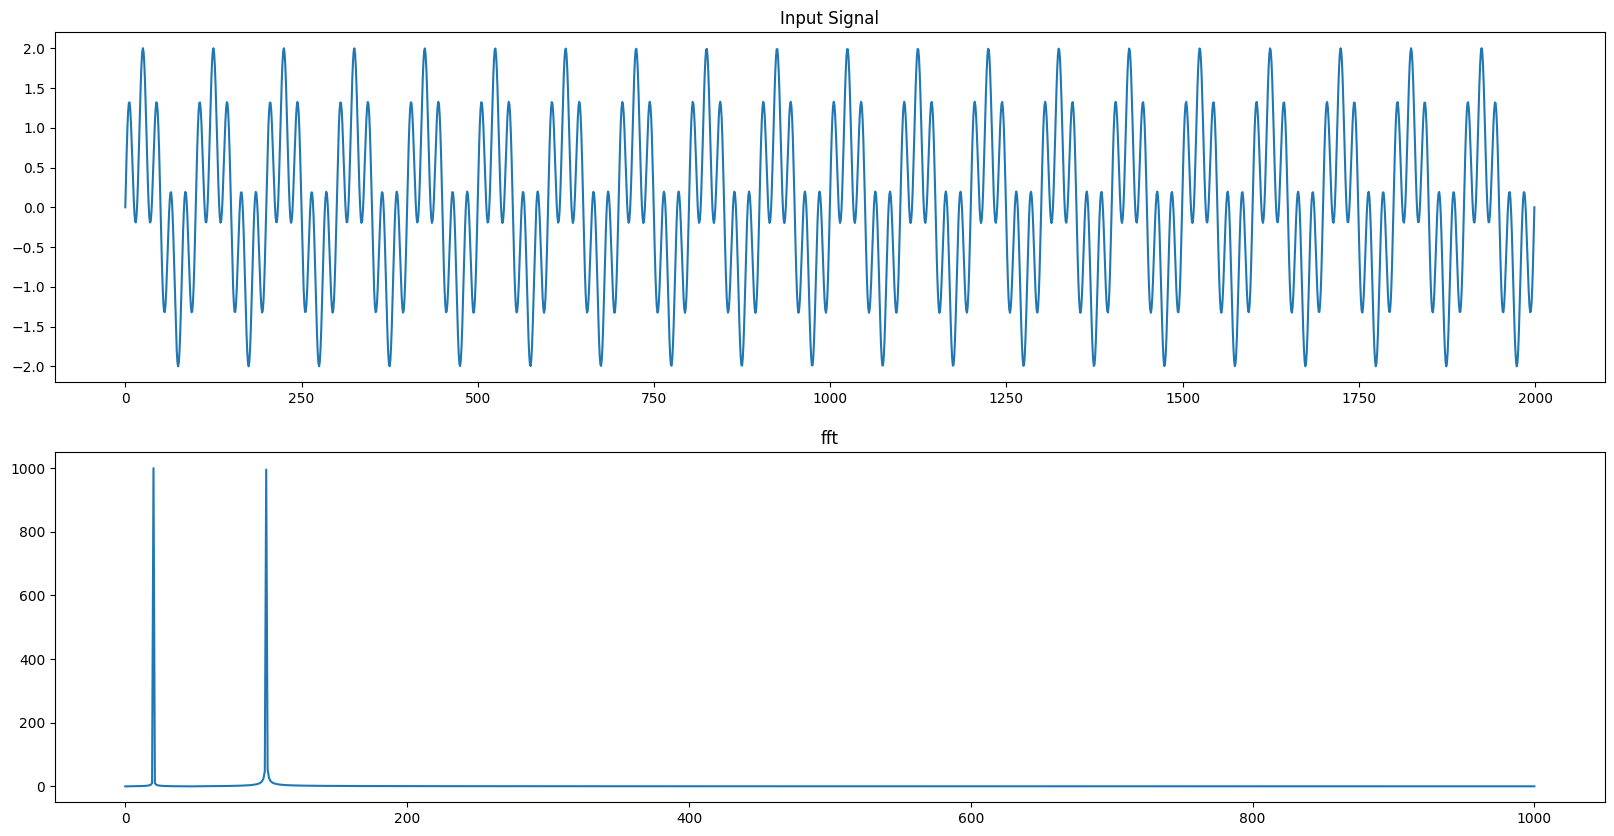

In [ ]:
# visualize different frequency components

fig,axis=plt.subplots(2,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
signal=tf.math.sin(x*2*np.pi*20) + tf.math.sin(x*2*np.pi*100) # Fourier transformation for an example sin wave; 
#x is frequency
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)#Real-valued fast Fourier transform; x-freq, y-amplitude

axis[1].plot(tf.abs(fft) 
)
axis[1].set_title("fft")


short-term fourier transforms can be stacked/aligned together

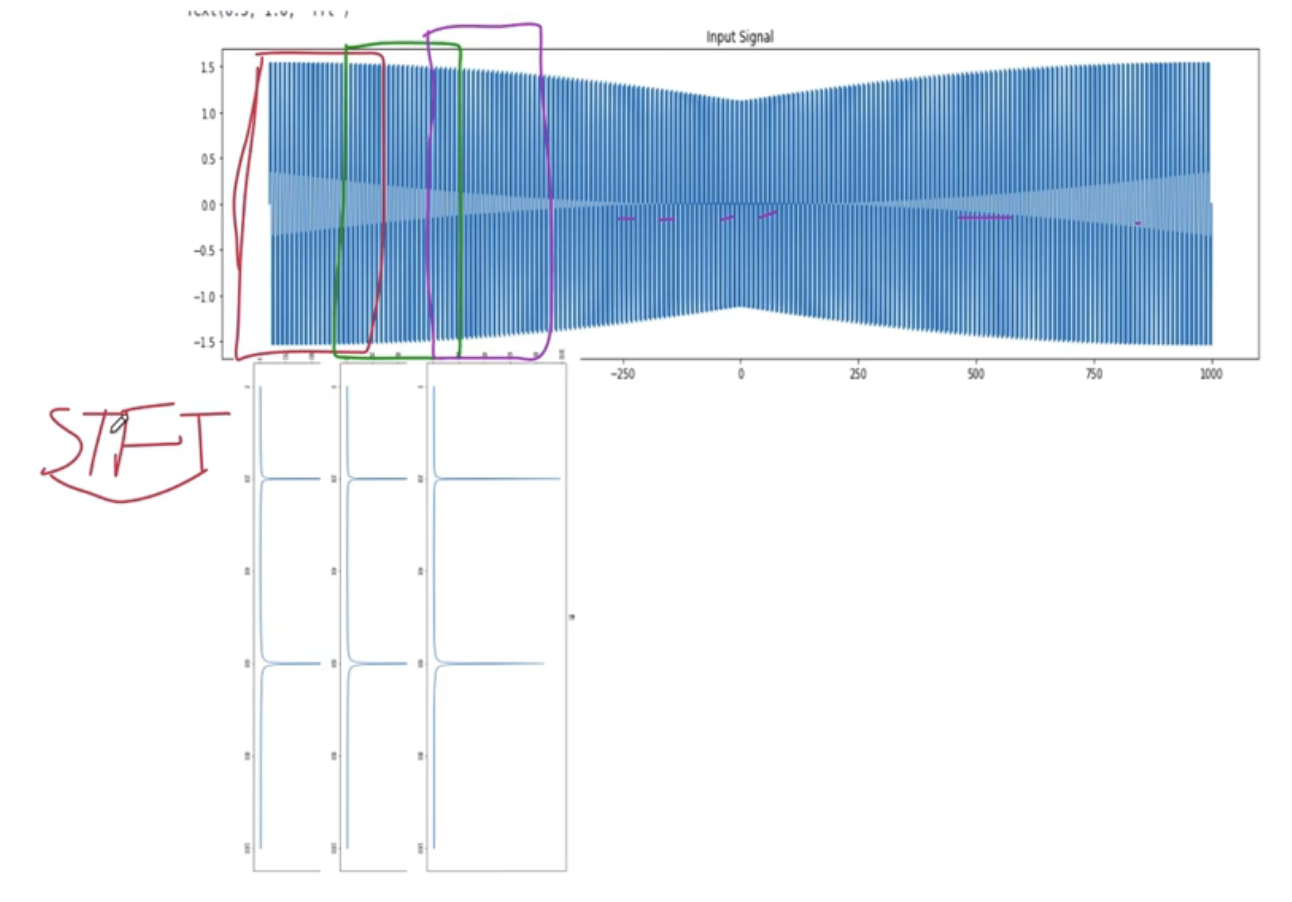

(2000,)


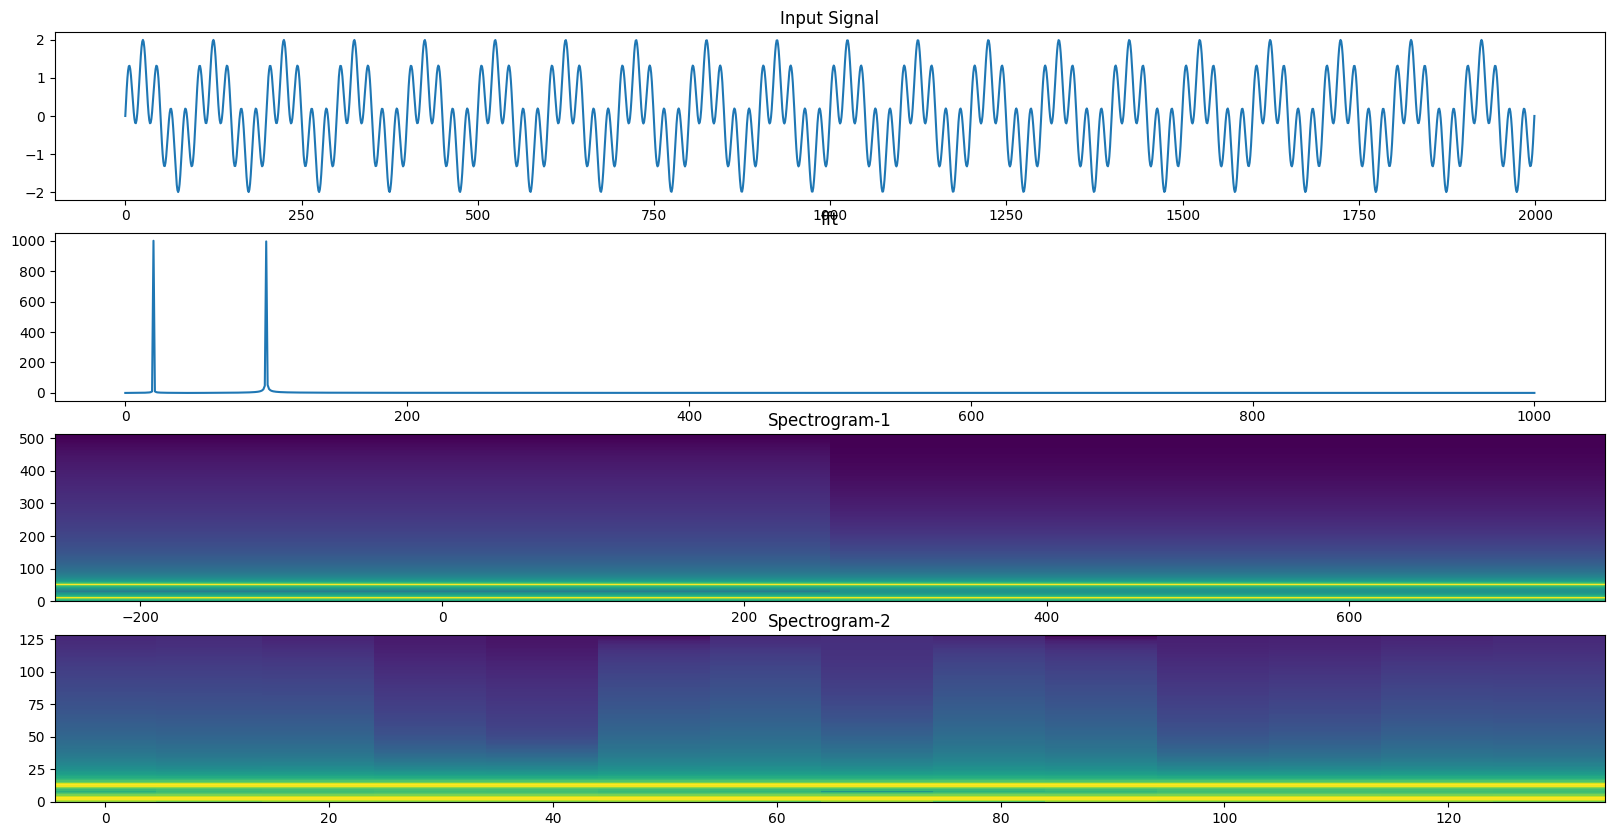

In [ ]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
# Fourier transformation: signal=tf.math.sin(x*2*np.pi*10) #x is frequency
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)#Real-valued fast Fourier transform.

axis[1].plot(tf.abs(fft) 
)
axis[1].set_title("fft")

spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,) #x-time, y-freq; smaller frame_length has higher f resolutions
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


# Data loading

In [ ]:
audio_text={}

In [ ]:
csv_path="/content/dataset/LJSpeech-1.1/metadata.csv"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split("|")[0] #filename
    text=line.strip().split("|")[1] #transcript
    audio_text[str(i)]=text
dict(list(audio_text.items())[:10])

{'LJ001-0001': 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 'LJ001-0002': 'in being comparatively modern.',
 'LJ001-0003': 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process',
 'LJ001-0004': 'produced the block books, which were the immediate predecessors of the true printed book,',
 'LJ001-0005': 'the invention of movable metal letters in the middle of the fifteenth century may justly be considered as the invention of the art of printing.',
 'LJ001-0006': 'And it is worth mention in passing that, as an example of fine typography,',
 'LJ001-0007': 'the earliest book printed with movable types, the Gutenberg, or "forty-two line Bible" of about 1455,',
 'LJ001-0008': 'has never been surpassed.',
 'LJ001-0009': 'Printing, then, for our purpose, may be considered as the art of

In [ ]:
# align filepaths and transcripts
filepaths=["/content/dataset/LJSpeech-1.1/wavs/"+filename+".wav" for filename in list(audio_text.keys())]
transcriptions=[audio_text[str(filename)].lower() for filename in list(audio_text.keys())]
print(len(filepaths))
print(len(transcriptions))

13100
13100


In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

# check the tokens
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/LJSpeech-1.1/wavs/LJ001-0001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'>)


In [ ]:
# decode audios in bulk
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [ ]:
# character dictionary
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "] #"" for unknown; 97 - (97+26) are a-z
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [ ]:
# index letters
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [ ]:
# change audio into stft
def get_spec(filepath,label):
  
  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)
  
  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [ ]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE) #keep the same length for every input
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [ ]:
# test inputs
for i,j in train_dataset.take(1): #shape: batch, length, vocab for each time step
  print(i,j)

tf.Tensor(
[[[[7.12798326e-04]
   [4.62571252e-03]
   [6.20642118e-03]
   ...
   [1.35252572e-04]
   [7.60570110e-05]
   [3.36043013e-05]]

  [[4.23590001e-03]
   [7.16409134e-03]
   [3.25928186e-03]
   ...
   [9.35634525e-05]
   [5.88791190e-05]
   [2.21005175e-05]]

  [[3.52023495e-03]
   [1.79913249e-02]
   [2.51728334e-02]
   ...
   [3.46485089e-04]
   [1.54136491e-04]
   [1.43282465e-04]]

  ...

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]]


 [[[5.27175982e-03]
   [8.09575431e-03]
   [1.60869583e-02]
   ...
   [1.84492674e-04]
   [1.14722949e-04]
   [1.01984711e-04]]

  [[5.57353161e-03]
   [1.64909046e-02]
   [1.31872818e-01]
   ...
   [1.4465

# Modeling

model structure
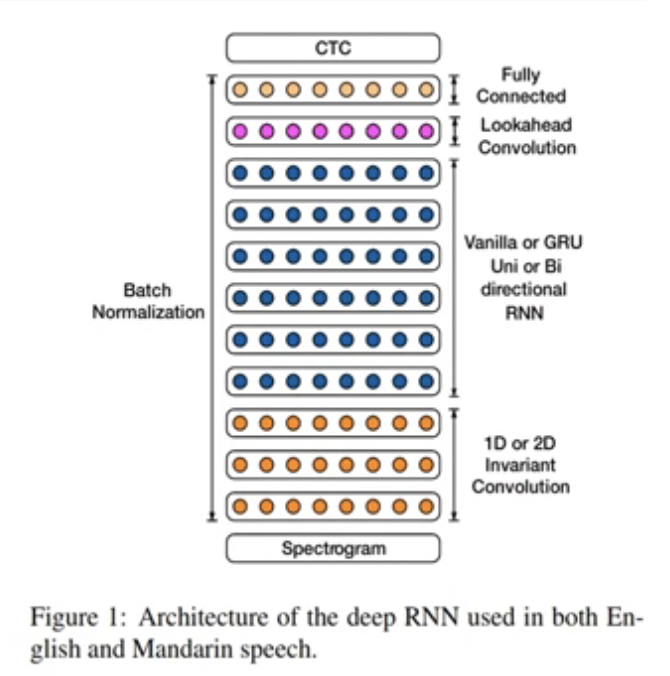

In [ ]:
normalization=tf.keras.layers.Normalization()

parameters come from the paper

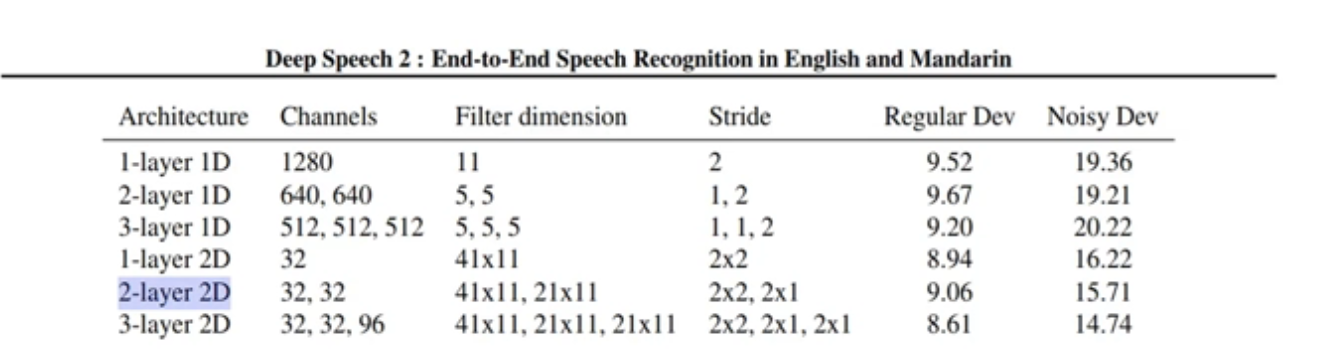

In [ ]:
input_spectrogram=Input((None, 129, 1),name='input') #129 is a decision to capture the human frequency range

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)

output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech")
model.summary()

Model: "DeepSpeech"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizatio  (None, None, 129, 1)     3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (LayerN  (None, None, 65, 32)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Laye  (None, None, 33, 64)     1

In [ ]:
""" define ctc loss function (connectionist temporal classification)
motivation: the output from layers is (batch,length, vocab) 
and the final label is mismatched with it (vary in length)
The main idea is to add a mask label as an end of the output like [LINK]"""

def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]
  
  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32) #make sure each batch length has its own length
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)
  
  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [ ]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [ ]:
#we can load weights from another pre-trained model
#model.load_weights('/content/drive/MyDrive/nlp/ctc_keras.h5')

In [ ]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS
)

Epoch 1/100
  8/389 [..............................] - ETA: 7:01:12 - loss: 730.1154

KeyboardInterrupt: ignored

### ***training is not finished because of hardware***

# Testing

In [ ]:
def get_spec_inference(filepath):
  
  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)
  
  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
      
  spectrogram=tf.abs(spectrogram)
  
  return tf.expand_dims(spectrogram,axis=-1)

In [ ]:
test_path="/content/LJ001-0005.wav"

In [ ]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)

In [ ]:
out

In [ ]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)
print(out_str)

In [ ]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)# ensure each has its own length
  
  y_pred=tf.one_hot(y_pred,len(vocabulary)+1) #convert the vocab to one-hot query
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0] #main part of decoding outputs
  
  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)
print(decode(tf.expand_dims(out,axis=0)))